# Neoclassical transport calculations for axisymmetric plasmas

## Define particles in our simulation

In [2]:
import astropy.units as u
import numpy as np

from plasmapy.particles import IonizationStateCollection

all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)

<IonizationStateCollection for: H, C>

## `SymbolicEquilibrium`

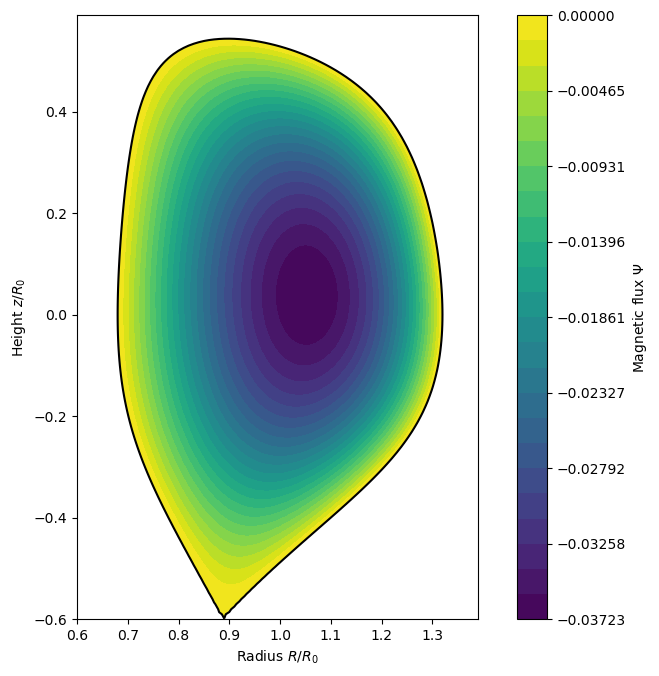

In [3]:
from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = {"aspect_ratio": 0.32, "A": -0.155, "elongation": 1.7, "triangularity": 0.33}
eq = SymbolicEquilibrium(**params, B0=5.2, config="single-null")
eq.plot();

## `FluxSurface`

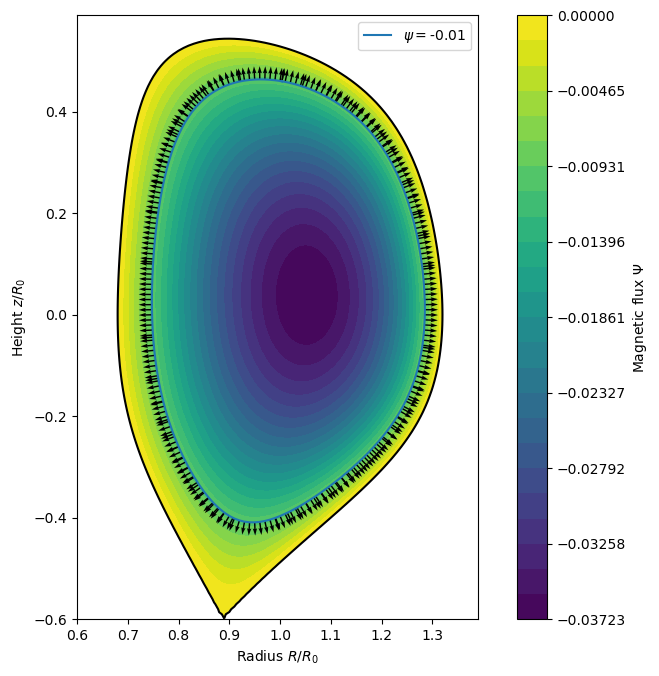

In [4]:
ax = eq.plot()
flux_surface = eq.get_flux_surface(-0.01)
flux_surface.plot(ax, n=True);

## Multiple flux surfaces - radial grid

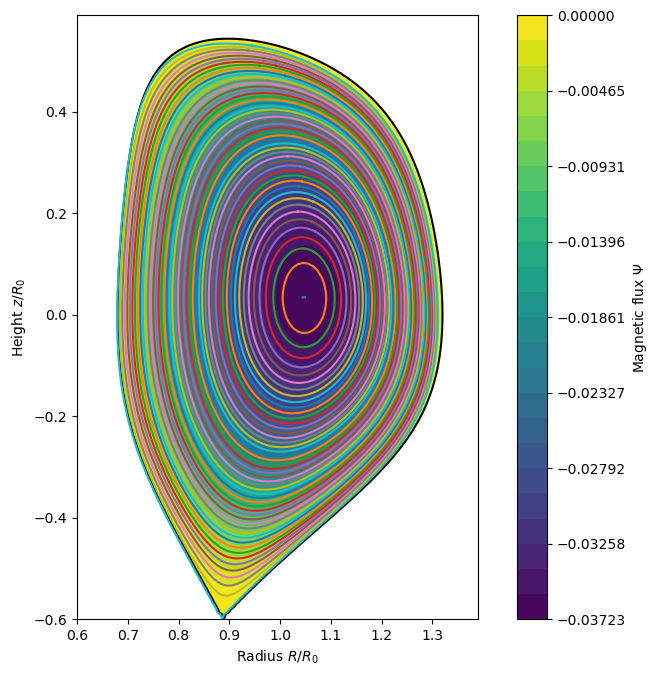

In [5]:
ax = eq.plot()
for fs in eq.get_multiple_flux_surfaces(np.linspace(-0.037228, 0, 50)):
    fs.plot(ax)
ax.legend().remove()

## `FlowCalculator`

In [6]:
from plasmapy.transport.flows import FlowCalculator

density_gradient = {
    "H 1+": 1e18 * u.m ** -3 / u.m,
    "C 1+": 1e18 * u.m ** -3 / u.m,
}
temperature_gradient = {
    "H 1+": (-1 * u.eV).to(u.K, equivalencies=u.temperature_energy()) / u.m,
    "C 1+": (-1 * u.eV).to(u.K, equivalencies=u.temperature_energy()) / u.m,
}

fc = FlowCalculator(all_species, flux_surface, density_gradient, temperature_gradient)

### Units

In [7]:
sym = "H 1+"
S_pt = fc.S_pt[sym]

<Quantity [ 0.00128004, -0.00467272,  0.        ] N T / m3>

In [8]:
Aai = fc.Aai[sym]

<Quantity [[-1.24280783,  1.55273521, -1.68617992],
           [ 1.55273521,  4.00408902,  4.64710622],
           [-1.68617992,  4.64710622, -7.80444627]] kg / (m3 s)>

In [9]:
H = fc.all_species["H"]

<IonizationState instance for H>

In [10]:
(S_pt / Aai).si

<Quantity [[-0.00102996, -0.00300935, -0.        ],
           [ 0.00082438, -0.00116699,  0.        ],
           [-0.00075913, -0.00100551, -0.        ]] V / m>

### Bootstrap current

In [11]:
fc.bootstrap_current.si  # TODO should be A/m^2? missing a magnetic field in the denominator somewhere?

<Quantity -0.02879324 Pa / m>

In [12]:
(fc.bootstrap_current / u.T).to(u.A / u.m ** 2)

<Quantity -0.02879324 A / m2>

### Fluxes

The units are horribly off for each of them atm.

In [13]:
flux_unit = u.m ** -2 / u.s

Unit("1 / (m2 s)")

In [14]:
fc._fluxes_BP

{'H 1+': Fluxes(particle_flux=<Quantity -7.98501624e+15 1 / (m2 s)>, heat_flux=<Quantity 0.04670417 kg / s3>),
 'C 6+': Fluxes(particle_flux=<Quantity 1.14384766e+09 1 / (m2 s)>, heat_flux=<Quantity -1.78151124e-10 kg / s3>)}

In [15]:
fc._fluxes_BP["H 1+"].particle_flux.to(flux_unit)

<Quantity -7.98501624e+15 1 / (m2 s)>

In [16]:
fc._fluxes_BP["H 1+"].heat_flux.to(u.J * flux_unit)

<Quantity 0.04670417 J / (m2 s)>

In [17]:
fc._fluxes_CL

{'H 1+': Fluxes(particle_flux=<Quantity -1.12773871e+15 Pa / m5>, heat_flux=<Quantity -0.00453989 kg2 / (m4 s4)>),
 'C 6+': Fluxes(particle_flux=<Quantity 1.63916787e+14 Pa / m5>, heat_flux=<Quantity -8.14217635e-05 kg2 / (m4 s4)>)}

In [18]:
(fc._fluxes_CL["H 1+"].particle_flux / (u.kg / u.s / u.m ** 4)).to(flux_unit)

<Quantity -1.12773871e+15 1 / (m2 s)>

In [19]:
(fc._fluxes_CL["H 1+"].heat_flux / (u.kg / u.s / u.m ** 4)).to(u.J * flux_unit)

<Quantity -0.00453989 J / (m2 s)>

In [20]:
fc._fluxes_PS

{'H 1+': Fluxes(particle_flux=<Quantity -7.31905529e+15 Pa / m4>, heat_flux=<Quantity -0.02946402 kg2 / (m3 s4)>),
 'C 6+': Fluxes(particle_flux=<Quantity 1.06382447e+15 Pa / m4>, heat_flux=<Quantity -0.00052843 kg2 / (m3 s4)>)}

In [21]:
(fc._fluxes_PS["H 1+"].particle_flux / (u.kg / u.s / u.m ** 3)).to(flux_unit)

<Quantity -7.31905529e+15 1 / (m2 s)>

In [22]:
(fc._fluxes_PS["H 1+"].heat_flux / (u.kg / u.s / u.m ** 3)).to(u.J * flux_unit)

<Quantity -0.02946402 J / (m2 s)>

In [23]:
flux_unit = u.m ** -2 / u.s

Unit("1 / (m2 s)")

In [24]:
[
    (flux[sym].particle_flux.unit.si / flux_unit).si
    for flux in [fc._fluxes_BP, fc._fluxes_CL, fc._fluxes_PS]
]

[Unit(dimensionless), Unit("kg / (m4 s)"), Unit("kg / (m3 s)")]

In [25]:
[
    (flux[sym].heat_flux.unit / flux_unit / u.J).si
    for flux in [fc._fluxes_BP, fc._fluxes_CL, fc._fluxes_PS]
]

[Unit(dimensionless), Unit("kg / (m4 s)"), Unit("kg / (m3 s)")]